<a href="https://colab.research.google.com/github/OUARAS-khelil-Rafik/AS-Ooredoo_Djezzy_Mobilis-/blob/main/Training_AS_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

In [ ]:
%pip install torch torchvision torchaudio scikit-learn matplotlib tqdm pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Device: cuda


Epoch 1 [Training]: 100%|██████████| 80/80 [00:00<00:00, 143.67it/s, loss=1.1]



Epoch 1 - Train Loss: 1.0989, Val Loss: 1.0975, Train Acc: 0.3092, Val Acc: 0.4641


Epoch 2 [Training]: 100%|██████████| 80/80 [00:00<00:00, 181.30it/s, loss=1.08]



Epoch 2 - Train Loss: 1.0955, Val Loss: 1.0937, Train Acc: 0.4535, Val Acc: 0.4365


Epoch 3 [Training]: 100%|██████████| 80/80 [00:00<00:00, 190.60it/s, loss=1.08]



Epoch 3 - Train Loss: 1.0898, Val Loss: 1.0865, Train Acc: 0.4377, Val Acc: 0.4365


Epoch 4 [Training]: 100%|██████████| 80/80 [00:00<00:00, 181.26it/s, loss=1.11]



Epoch 4 - Train Loss: 1.0771, Val Loss: 1.0697, Train Acc: 0.4401, Val Acc: 0.4365


Epoch 5 [Training]: 100%|██████████| 80/80 [00:00<00:00, 182.87it/s, loss=1]



Epoch 5 - Train Loss: 1.0487, Val Loss: 1.0367, Train Acc: 0.4460, Val Acc: 0.4503


Epoch 6 [Training]: 100%|██████████| 80/80 [00:00<00:00, 184.02it/s, loss=0.668]



Epoch 6 - Train Loss: 1.0077, Val Loss: 1.0023, Train Acc: 0.4650, Val Acc: 0.4475


Epoch 7 [Training]: 100%|██████████| 80/80 [00:00<00:00, 185.86it/s, loss=0.828]



Epoch 7 - Train Loss: 0.9745, Val Loss: 0.9773, Train Acc: 0.5049, Val Acc: 0.4834


Epoch 8 [Training]: 100%|██████████| 80/80 [00:00<00:00, 185.29it/s, loss=0.573]



Epoch 8 - Train Loss: 0.9476, Val Loss: 0.9570, Train Acc: 0.5488, Val Acc: 0.5304


Epoch 9 [Training]: 100%|██████████| 80/80 [00:00<00:00, 186.11it/s, loss=1.04]



Epoch 9 - Train Loss: 0.9239, Val Loss: 0.9380, Train Acc: 0.6018, Val Acc: 0.5691


Epoch 10 [Training]: 100%|██████████| 80/80 [00:00<00:00, 181.26it/s, loss=1.11]



Epoch 10 - Train Loss: 0.9007, Val Loss: 0.9204, Train Acc: 0.6548, Val Acc: 0.6271


Epoch 11 [Training]: 100%|██████████| 80/80 [00:00<00:00, 180.86it/s, loss=1.17]



Epoch 11 - Train Loss: 0.8784, Val Loss: 0.9036, Train Acc: 0.6959, Val Acc: 0.6354


Epoch 12 [Training]: 100%|██████████| 80/80 [00:00<00:00, 179.68it/s, loss=0.685]



Epoch 12 - Train Loss: 0.8594, Val Loss: 0.8880, Train Acc: 0.7252, Val Acc: 0.6740


Epoch 13 [Training]: 100%|██████████| 80/80 [00:00<00:00, 166.47it/s, loss=0.997]



Epoch 13 - Train Loss: 0.8378, Val Loss: 0.8732, Train Acc: 0.7651, Val Acc: 0.6851


Epoch 14 [Training]: 100%|██████████| 80/80 [00:00<00:00, 150.37it/s, loss=0.915]



Epoch 14 - Train Loss: 0.8172, Val Loss: 0.8580, Train Acc: 0.8039, Val Acc: 0.7155


Epoch 15 [Training]: 100%|██████████| 80/80 [00:00<00:00, 162.76it/s, loss=0.553]



Epoch 15 - Train Loss: 0.7960, Val Loss: 0.8425, Train Acc: 0.8406, Val Acc: 0.7459


Epoch 16 [Training]: 100%|██████████| 80/80 [00:00<00:00, 156.63it/s, loss=0.99]



Epoch 16 - Train Loss: 0.7725, Val Loss: 0.8261, Train Acc: 0.8656, Val Acc: 0.7707


Epoch 17 [Training]: 100%|██████████| 80/80 [00:00<00:00, 146.10it/s, loss=0.551]



Epoch 17 - Train Loss: 0.7502, Val Loss: 0.8105, Train Acc: 0.8845, Val Acc: 0.7652


Epoch 18 [Training]: 100%|██████████| 80/80 [00:00<00:00, 190.03it/s, loss=0.736]



Epoch 18 - Train Loss: 0.7289, Val Loss: 0.7972, Train Acc: 0.8917, Val Acc: 0.7956


Epoch 19 [Training]: 100%|██████████| 80/80 [00:00<00:00, 189.22it/s, loss=1.45]



Epoch 19 - Train Loss: 0.7098, Val Loss: 0.7858, Train Acc: 0.9011, Val Acc: 0.7956


Epoch 20 [Training]: 100%|██████████| 80/80 [00:00<00:00, 182.23it/s, loss=0.573]



Epoch 20 - Train Loss: 0.6974, Val Loss: 0.7767, Train Acc: 0.9019, Val Acc: 0.7983


Epoch 21 [Training]: 100%|██████████| 80/80 [00:00<00:00, 180.45it/s, loss=0.845]



Epoch 21 - Train Loss: 0.6828, Val Loss: 0.7688, Train Acc: 0.9063, Val Acc: 0.8094


Epoch 22 [Training]: 100%|██████████| 80/80 [00:00<00:00, 179.54it/s, loss=0.551]



Epoch 22 - Train Loss: 0.6758, Val Loss: 0.7625, Train Acc: 0.9091, Val Acc: 0.8094


Epoch 23 [Training]: 100%|██████████| 80/80 [00:00<00:00, 162.55it/s, loss=0.558]



Epoch 23 - Train Loss: 0.6650, Val Loss: 0.7564, Train Acc: 0.9174, Val Acc: 0.8177


Epoch 24 [Training]: 100%|██████████| 80/80 [00:00<00:00, 98.40it/s, loss=0.657] 



Epoch 24 - Train Loss: 0.6581, Val Loss: 0.7512, Train Acc: 0.9197, Val Acc: 0.8177


Epoch 25 [Training]: 100%|██████████| 80/80 [00:00<00:00, 93.34it/s, loss=0.551]



Epoch 25 - Train Loss: 0.6504, Val Loss: 0.7467, Train Acc: 0.9272, Val Acc: 0.8287


Epoch 26 [Training]: 100%|██████████| 80/80 [00:00<00:00, 108.25it/s, loss=1.44]



Epoch 26 - Train Loss: 0.6478, Val Loss: 0.7424, Train Acc: 0.9249, Val Acc: 0.8287


Epoch 27 [Training]: 100%|██████████| 80/80 [00:00<00:00, 99.10it/s, loss=0.551]



Epoch 27 - Train Loss: 0.6413, Val Loss: 0.7393, Train Acc: 0.9288, Val Acc: 0.8287


Epoch 28 [Training]: 100%|██████████| 80/80 [00:00<00:00, 123.14it/s, loss=0.599]



Epoch 28 - Train Loss: 0.6373, Val Loss: 0.7363, Train Acc: 0.9328, Val Acc: 0.8232


Epoch 29 [Training]: 100%|██████████| 80/80 [00:00<00:00, 130.91it/s, loss=0.958]



Epoch 29 - Train Loss: 0.6335, Val Loss: 0.7333, Train Acc: 0.9344, Val Acc: 0.8260


Epoch 30 [Training]: 100%|██████████| 80/80 [00:00<00:00, 140.51it/s, loss=0.551]



Epoch 30 - Train Loss: 0.6310, Val Loss: 0.7303, Train Acc: 0.9328, Val Acc: 0.8232


Epoch 31 [Training]: 100%|██████████| 80/80 [00:00<00:00, 131.52it/s, loss=0.67]



Epoch 31 - Train Loss: 0.6268, Val Loss: 0.7277, Train Acc: 0.9387, Val Acc: 0.8232


Epoch 32 [Training]: 100%|██████████| 80/80 [00:00<00:00, 135.20it/s, loss=0.551]



Epoch 32 - Train Loss: 0.6252, Val Loss: 0.7255, Train Acc: 0.9355, Val Acc: 0.8287


Epoch 33 [Training]: 100%|██████████| 80/80 [00:00<00:00, 96.18it/s, loss=0.57]



Epoch 33 - Train Loss: 0.6218, Val Loss: 0.7244, Train Acc: 0.9423, Val Acc: 0.8287


Epoch 34 [Training]: 100%|██████████| 80/80 [00:01<00:00, 79.13it/s, loss=0.551]



Epoch 34 - Train Loss: 0.6214, Val Loss: 0.7223, Train Acc: 0.9415, Val Acc: 0.8343


Epoch 35 [Training]: 100%|██████████| 80/80 [00:00<00:00, 94.50it/s, loss=0.551]



Epoch 35 - Train Loss: 0.6166, Val Loss: 0.7208, Train Acc: 0.9482, Val Acc: 0.8343


Epoch 36 [Training]: 100%|██████████| 80/80 [00:00<00:00, 124.74it/s, loss=0.552]



Epoch 36 - Train Loss: 0.6171, Val Loss: 0.7192, Train Acc: 0.9431, Val Acc: 0.8370


Epoch 37 [Training]: 100%|██████████| 80/80 [00:00<00:00, 102.65it/s, loss=0.551]



Epoch 37 - Train Loss: 0.6135, Val Loss: 0.7173, Train Acc: 0.9462, Val Acc: 0.8398


Epoch 38 [Training]: 100%|██████████| 80/80 [00:00<00:00, 159.88it/s, loss=0.552]



Epoch 38 - Train Loss: 0.6122, Val Loss: 0.7157, Train Acc: 0.9466, Val Acc: 0.8398


Epoch 39 [Training]: 100%|██████████| 80/80 [00:00<00:00, 184.23it/s, loss=0.551]



Epoch 39 - Train Loss: 0.6118, Val Loss: 0.7149, Train Acc: 0.9482, Val Acc: 0.8425


Epoch 40 [Training]: 100%|██████████| 80/80 [00:00<00:00, 180.32it/s, loss=0.553]



Epoch 40 - Train Loss: 0.6090, Val Loss: 0.7135, Train Acc: 0.9514, Val Acc: 0.8453


Epoch 41 [Training]: 100%|██████████| 80/80 [00:00<00:00, 184.08it/s, loss=0.554]



Epoch 41 - Train Loss: 0.6056, Val Loss: 0.7125, Train Acc: 0.9553, Val Acc: 0.8453


Epoch 42 [Training]: 100%|██████████| 80/80 [00:00<00:00, 182.51it/s, loss=0.552]



Epoch 42 - Train Loss: 0.6066, Val Loss: 0.7123, Train Acc: 0.9541, Val Acc: 0.8453


Epoch 43 [Training]: 100%|██████████| 80/80 [00:00<00:00, 183.06it/s, loss=1.05]



Epoch 43 - Train Loss: 0.6052, Val Loss: 0.7116, Train Acc: 0.9549, Val Acc: 0.8453


Epoch 44 [Training]: 100%|██████████| 80/80 [00:00<00:00, 180.91it/s, loss=0.553]



Epoch 44 - Train Loss: 0.6050, Val Loss: 0.7122, Train Acc: 0.9549, Val Acc: 0.8425


Epoch 45 [Training]: 100%|██████████| 80/80 [00:00<00:00, 183.11it/s, loss=0.559]



Epoch 45 - Train Loss: 0.6022, Val Loss: 0.7105, Train Acc: 0.9557, Val Acc: 0.8453


Epoch 46 [Training]: 100%|██████████| 80/80 [00:00<00:00, 182.39it/s, loss=0.567]



Epoch 46 - Train Loss: 0.6026, Val Loss: 0.7104, Train Acc: 0.9549, Val Acc: 0.8425


Epoch 47 [Training]: 100%|██████████| 80/80 [00:00<00:00, 184.07it/s, loss=0.551]



Epoch 47 - Train Loss: 0.6007, Val Loss: 0.7102, Train Acc: 0.9581, Val Acc: 0.8398


Epoch 48 [Training]: 100%|██████████| 80/80 [00:00<00:00, 181.39it/s, loss=0.552]



Epoch 48 - Train Loss: 0.6013, Val Loss: 0.7090, Train Acc: 0.9565, Val Acc: 0.8398


Epoch 49 [Training]: 100%|██████████| 80/80 [00:00<00:00, 171.36it/s, loss=0.601]



Epoch 49 - Train Loss: 0.5982, Val Loss: 0.7090, Train Acc: 0.9593, Val Acc: 0.8398


Epoch 50 [Training]: 100%|██████████| 80/80 [00:00<00:00, 182.79it/s, loss=0.59]



Epoch 50 - Train Loss: 0.5961, Val Loss: 0.7092, Train Acc: 0.9609, Val Acc: 0.8398


Epoch 51 [Training]: 100%|██████████| 80/80 [00:00<00:00, 183.53it/s, loss=0.552]



Epoch 51 - Train Loss: 0.5957, Val Loss: 0.7093, Train Acc: 0.9605, Val Acc: 0.8398
⛔ Early stopping triggered


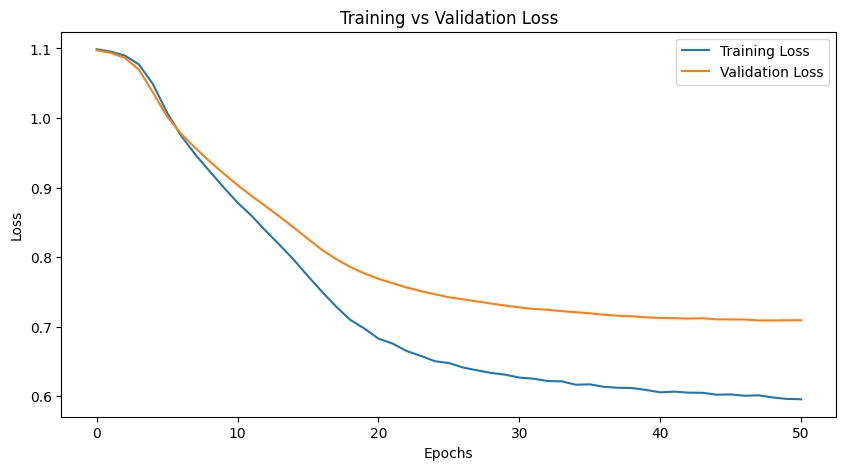


Classification Report:
              precision    recall  f1-score   support

     Negatif       0.91      0.80      0.85       172
      Neutre       0.78      0.83      0.80       236
     Positif       0.90      0.92      0.91       315

    accuracy                           0.86       723
   macro avg       0.86      0.85      0.85       723
weighted avg       0.86      0.86      0.86       723



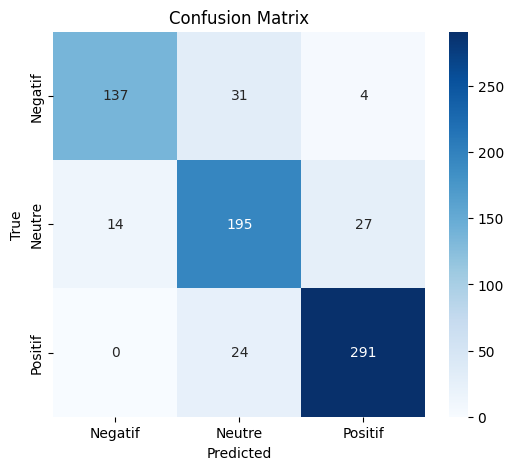

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# ✅ GPU seulement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 📁 Chargement des données
df = pd.read_csv("/content/Comments_clean.csv")
df = df.dropna(subset=["Comments"])

# 🎯 Encodage des étiquettes
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])

# ✂️ Division des données
X_temp, X_test, y_temp, y_test = train_test_split(df["Comments"], df["Sentiments_encoded"], test_size=0.2, random_state=42, stratify=df["Sentiments_encoded"])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)  # 0.125 * 0.8 = 0.1

# 🧠 Vectorisation avec CountVectorizer
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train).toarray()
X_val_vec = vectorizer.transform(X_val).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# 📦 Dataset personnalisé
class CommentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CommentDataset(X_train_vec, y_train)
val_dataset = CommentDataset(X_val_vec, y_val)
test_dataset = CommentDataset(X_test_vec, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# 🧱 Modèle LSTM
class SentimentLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
        super(SentimentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch_size, 1, input_dim]
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(out)
        return self.softmax(out)

input_dim = X_train_vec.shape[1]
model = SentimentLSTM(input_dim=input_dim, hidden_dim=128, output_dim=3, n_layers=2, dropout=0.5)
model = model.to(device)

# 🔧 Entraînement
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_val_loss = float('inf')
patience = 2  # Nombre d'époques sans amélioration avant l'arrêt anticipé
epochs_no_improve = 0

for epoch in range(100):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("⛔ Early stopping triggered")
            break

# 📉 Graphique des pertes
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# ✅ Évaluation finale
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 📊 Rapport de classification
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 📌 Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

---

# DziriBert

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


\n🟢 Epoch 1/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  9.35it/s]


✅ Train Loss: 0.9214 | Acc: 0.5524 - Val Loss: 0.5928 | Acc: 0.7410
\n🟢 Epoch 2/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  9.23it/s]


✅ Train Loss: 0.5503 | Acc: 0.7746 - Val Loss: 0.4064 | Acc: 0.8375
\n🟢 Epoch 3/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  9.34it/s]


✅ Train Loss: 0.3979 | Acc: 0.8434 - Val Loss: 0.3503 | Acc: 0.8457
\n🟢 Epoch 4/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  9.28it/s]


✅ Train Loss: 0.3289 | Acc: 0.8786 - Val Loss: 0.3295 | Acc: 0.8705
\n🟢 Epoch 5/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  9.22it/s]


✅ Train Loss: 0.2825 | Acc: 0.8968 - Val Loss: 0.3245 | Acc: 0.8733
\n🟢 Epoch 6/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  9.20it/s]


✅ Train Loss: 0.2584 | Acc: 0.9015 - Val Loss: 0.3242 | Acc: 0.8760
\n🟢 Epoch 7/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  9.22it/s]


✅ Train Loss: 0.2416 | Acc: 0.9095 - Val Loss: 0.3284 | Acc: 0.8815
\n🟢 Epoch 8/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  9.36it/s]


✅ Train Loss: 0.2389 | Acc: 0.9095 - Val Loss: 0.3244 | Acc: 0.8815
⛔ Early stopping triggered.
\n🔍 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.89      0.87      0.88       160
      Neutre       0.84      0.86      0.85       244
     Positif       0.93      0.92      0.92       318

    accuracy                           0.89       722
   macro avg       0.89      0.88      0.88       722
weighted avg       0.89      0.89      0.89       722



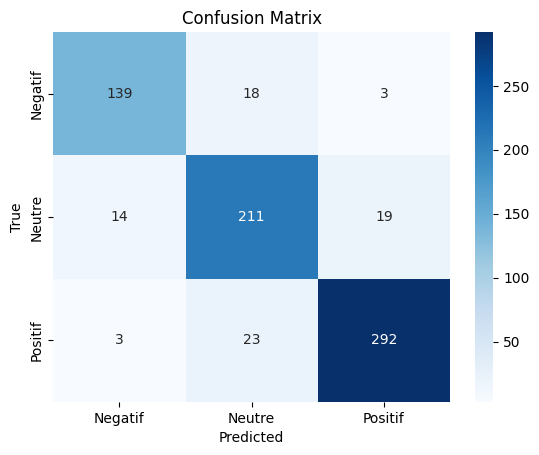

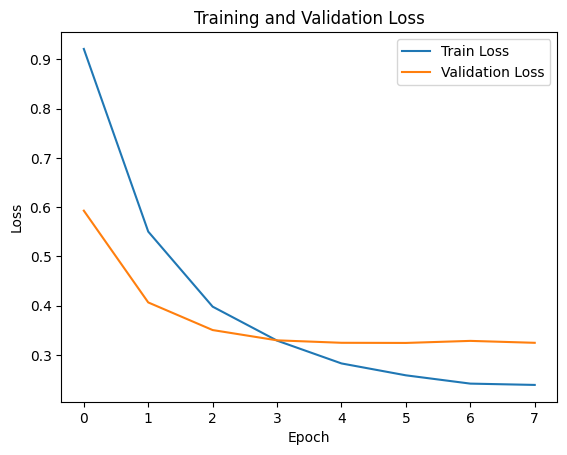

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import functional as F
from torch import nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random

# Configuration du device GPU uniquement
assert torch.cuda.is_available(), "CUDA GPU is not available."
device = torch.device("cuda")

# 1. Chargement des données
df = pd.read_csv("Comments_clean.csv").dropna(subset=["Comments"])

# 2. Encodage des sentiments
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])
num_labels = len(label_encoder.classes_)

# 3. Tokenizer et Dataset
tokenizer = AutoTokenizer.from_pretrained("alger-ia/dziribert")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# 4. Split dataset (Train 70%, Test 20%, Val 10%)
dataset = SentimentDataset(df["Comments"].values, df["Sentiments_encoded"].values, tokenizer)
total_size = len(dataset)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
val_size = total_size - train_size - test_size
train_set, test_set, val_set = random_split(dataset, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

# 5. Chargement du modèle avec dropout custom
config = AutoConfig.from_pretrained("alger-ia/dziribert", num_labels=num_labels, hidden_dropout_prob=0.4)
model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config)
model.to(device)

# 6. Optimiseur et Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=50, num_training_steps=num_training_steps)

# 7. Entraînement avec Early Stopping
best_val_loss = float("inf")
patience, patience_counter = 2, 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\\n🟢 Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"✅ Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# 8. Évaluation finale
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
all_preds, all_labels = [], []

for batch in test_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print("\\n🔍 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 9. Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 10. Courbes des pertes
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

---

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


\n🟢 Epoch 1/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.54it/s]


✅ Train Loss: 0.9737 | Acc: 0.5275 - Val Loss: 0.6558 | Acc: 0.7466
\n🟢 Epoch 2/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


✅ Train Loss: 0.6005 | Acc: 0.7655 - Val Loss: 0.4254 | Acc: 0.8320
\n🟢 Epoch 3/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


✅ Train Loss: 0.4285 | Acc: 0.8387 - Val Loss: 0.3583 | Acc: 0.8623
\n🟢 Epoch 4/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


✅ Train Loss: 0.3596 | Acc: 0.8569 - Val Loss: 0.3440 | Acc: 0.8678
\n🟢 Epoch 5/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


✅ Train Loss: 0.3126 | Acc: 0.8837 - Val Loss: 0.3421 | Acc: 0.8733
\n🟢 Epoch 6/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


✅ Train Loss: 0.3031 | Acc: 0.8905 - Val Loss: 0.3418 | Acc: 0.8733
\n🟢 Epoch 7/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


✅ Train Loss: 0.2628 | Acc: 0.8948 - Val Loss: 0.3374 | Acc: 0.8760
\n🟢 Epoch 8/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.52it/s]


✅ Train Loss: 0.2429 | Acc: 0.9027 - Val Loss: 0.3387 | Acc: 0.8788
\n🟢 Epoch 9/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


✅ Train Loss: 0.2470 | Acc: 0.9051 - Val Loss: 0.3384 | Acc: 0.8815
⛔ Early stopping triggered.
\n🔍 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.90      0.86      0.88       160
      Neutre       0.85      0.87      0.86       244
     Positif       0.93      0.93      0.93       318

    accuracy                           0.90       722
   macro avg       0.89      0.89      0.89       722
weighted avg       0.90      0.90      0.90       722



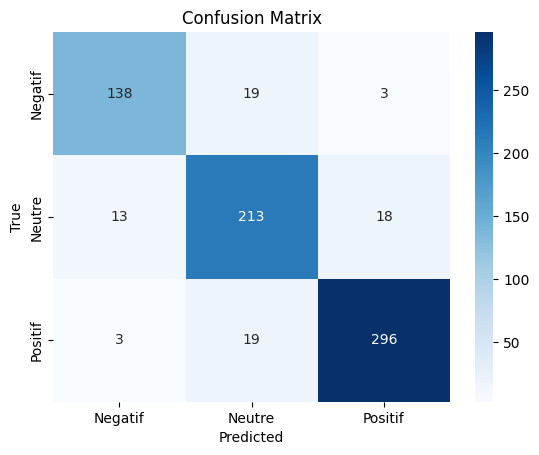

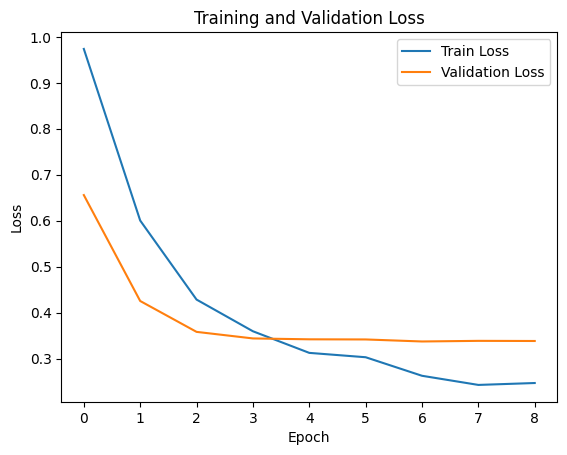

In [9]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import functional as F
from torch import nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random

# Configuration du device GPU uniquement
assert torch.cuda.is_available(), "CUDA GPU is not available."
device = torch.device("cuda")

# 1. Chargement des données
df = pd.read_csv("/content/Comments_clean.csv").dropna(subset=["Comments"])

# 2. Encodage des sentiments
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])
num_labels = len(label_encoder.classes_)

# 3. Tokenizer et Dataset
tokenizer = AutoTokenizer.from_pretrained("alger-ia/dziribert")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# 4. Split dataset (Train 70%, Test 20%, Val 10%)
dataset = SentimentDataset(df["Comments"].values, df["Sentiments_encoded"].values, tokenizer)
total_size = len(dataset)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
val_size = total_size - train_size - test_size
train_set, test_set, val_set = random_split(dataset, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

# 5. Chargement du modèle avec dropout custom
config = AutoConfig.from_pretrained("alger-ia/dziribert", num_labels=num_labels, hidden_dropout_prob=0.4)
model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config)
model.to(device)

# 6. Optimiseur et Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)

# 7. Entraînement avec Early Stopping
best_val_loss = float("inf")
patience, patience_counter = 2, 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\\n🟢 Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"✅ Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# 8. Évaluation finale
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
all_preds, all_labels = [], []

for batch in test_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print("\\n🔍 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 9. Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 10. Courbes des pertes
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import functional as F
from torch import nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random

# Configuration du device GPU uniquement
assert torch.cuda.is_available(), "CUDA GPU is not available."
device = torch.device("cuda")

# 1. Chargement des données
df = pd.read_csv("/content/Comments_clean.csv").dropna(subset=["Comments"])

# 2. Encodage des sentiments
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])
num_labels = len(label_encoder.classes_)

# 3. Tokenizer et Dataset
tokenizer = AutoTokenizer.from_pretrained("alger-ia/dziribert")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# 4. Split dataset (Train 70%, Test 20%, Val 10%)
dataset = SentimentDataset(df["Comments"].values, df["Sentiments_encoded"].values, tokenizer)
total_size = len(dataset)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
val_size = total_size - train_size - test_size
train_set, test_set, val_set = random_split(dataset, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

# 5. Chargement du modèle avec dropout custom
config = AutoConfig.from_pretrained("alger-ia/dziribert", num_labels=num_labels, hidden_dropout_prob=0.4)
model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config)
model.to(device)

# 6. Optimiseur et Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.9)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)

# 7. Entraînement avec Early Stopping
best_val_loss = float("inf")
patience, patience_counter = 2, 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\\n🟢 Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"✅ Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# 8. Évaluation finale
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
all_preds, all_labels = [], []

for batch in test_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print("\\n🔍 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 9. Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 10. Courbes des pertes
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Comments_clean.csv'

# Meilleur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


\n🟢 Epoch 1/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


✅ Train Loss: 0.9573 | Acc: 0.5603 - Val Loss: 0.7013 | Acc: 0.7190
\n🟢 Epoch 2/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


✅ Train Loss: 0.6316 | Acc: 0.7635 - Val Loss: 0.4802 | Acc: 0.8099
\n🟢 Epoch 3/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]


✅ Train Loss: 0.4672 | Acc: 0.8296 - Val Loss: 0.3870 | Acc: 0.8485
\n🟢 Epoch 4/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.81it/s]


✅ Train Loss: 0.3693 | Acc: 0.8608 - Val Loss: 0.3527 | Acc: 0.8705
\n🟢 Epoch 5/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.74it/s]


✅ Train Loss: 0.3236 | Acc: 0.8849 - Val Loss: 0.3363 | Acc: 0.8733
\n🟢 Epoch 6/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


✅ Train Loss: 0.2804 | Acc: 0.8952 - Val Loss: 0.3329 | Acc: 0.8678
\n🟢 Epoch 7/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]


✅ Train Loss: 0.2713 | Acc: 0.8984 - Val Loss: 0.3291 | Acc: 0.8705
\n🟢 Epoch 8/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


✅ Train Loss: 0.2501 | Acc: 0.9055 - Val Loss: 0.3280 | Acc: 0.8733
\n🟢 Epoch 9/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.75it/s]


✅ Train Loss: 0.2577 | Acc: 0.9106 - Val Loss: 0.3283 | Acc: 0.8788
\n🟢 Epoch 10/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.75it/s]


✅ Train Loss: 0.2405 | Acc: 0.9098 - Val Loss: 0.3282 | Acc: 0.8760
⛔ Early stopping triggered.
\n🔍 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.87      0.87      0.87       160
      Neutre       0.85      0.84      0.84       244
     Positif       0.92      0.93      0.92       318

    accuracy                           0.89       722
   macro avg       0.88      0.88      0.88       722
weighted avg       0.88      0.89      0.88       722



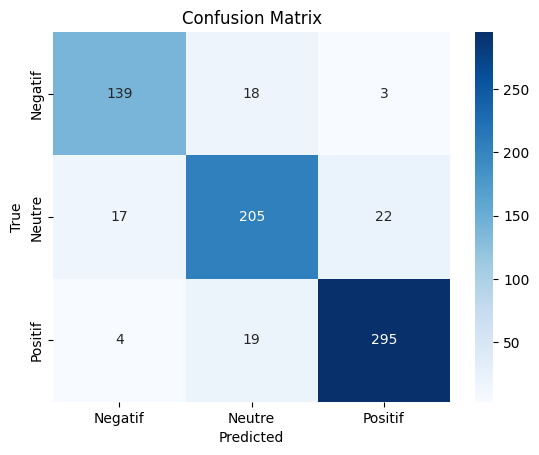

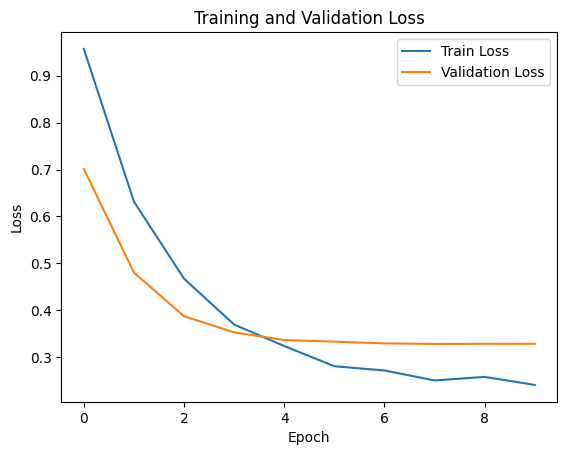

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import functional as F
from torch import nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random

# Configuration du device GPU uniquement
assert torch.cuda.is_available(), "CUDA GPU is not available."
device = torch.device("cuda")

# 1. Chargement des données
df = pd.read_csv("/content/Comments_clean.csv").dropna(subset=["Comments"])

# 2. Encodage des sentiments
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])
num_labels = len(label_encoder.classes_)

# 3. Tokenizer et Dataset
tokenizer = AutoTokenizer.from_pretrained("alger-ia/dziribert")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# 4. Split dataset (Train 70%, Test 20%, Val 10%)
dataset = SentimentDataset(df["Comments"].values, df["Sentiments_encoded"].values, tokenizer)
total_size = len(dataset)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
val_size = total_size - train_size - test_size
train_set, test_set, val_set = random_split(dataset, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

# 5. Chargement du modèle avec dropout custom
config = AutoConfig.from_pretrained("alger-ia/dziribert", num_labels=num_labels, hidden_dropout_prob=0.3)
model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config)
model.to(device)

# 6. Optimiseur et Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01, eps=0.001)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)

# 7. Entraînement avec Early Stopping
best_val_loss = float("inf")
patience, patience_counter = 2, 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\\n🟢 Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"✅ Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# 8. Évaluation finale
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
all_preds, all_labels = [], []

for batch in test_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print("\\n🔍 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 9. Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 10. Courbes des pertes
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

---

# Meilleur 02

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


\n🟢 Epoch 1/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  9.04it/s]


✅ Train Loss: 0.8639 | Acc: 0.5915 - Val Loss: 0.5430 | Acc: 0.7824
\n🟢 Epoch 2/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.66it/s]


✅ Train Loss: 0.4494 | Acc: 0.8193 - Val Loss: 0.3283 | Acc: 0.8650
\n🟢 Epoch 3/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.74it/s]


✅ Train Loss: 0.3176 | Acc: 0.8798 - Val Loss: 0.3295 | Acc: 0.8760
\n🟢 Epoch 4/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]


✅ Train Loss: 0.2729 | Acc: 0.8940 - Val Loss: 0.3283 | Acc: 0.8898
\n🟢 Epoch 5/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.76it/s]


✅ Train Loss: 0.2241 | Acc: 0.9185 - Val Loss: 0.3181 | Acc: 0.8760
\n🟢 Epoch 6/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.75it/s]


✅ Train Loss: 0.2004 | Acc: 0.9296 - Val Loss: 0.3177 | Acc: 0.8788
\n🟢 Epoch 7/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]


✅ Train Loss: 0.1733 | Acc: 0.9391 - Val Loss: 0.3068 | Acc: 0.8788
\n🟢 Epoch 8/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


✅ Train Loss: 0.1713 | Acc: 0.9348 - Val Loss: 0.3122 | Acc: 0.8926
\n🟢 Epoch 9/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.80it/s]


✅ Train Loss: 0.1577 | Acc: 0.9352 - Val Loss: 0.3122 | Acc: 0.8926
⛔ Early stopping triggered.
\n🔍 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.89      0.88      0.89       160
      Neutre       0.88      0.86      0.87       244
     Positif       0.92      0.94      0.93       318

    accuracy                           0.90       722
   macro avg       0.90      0.89      0.90       722
weighted avg       0.90      0.90      0.90       722



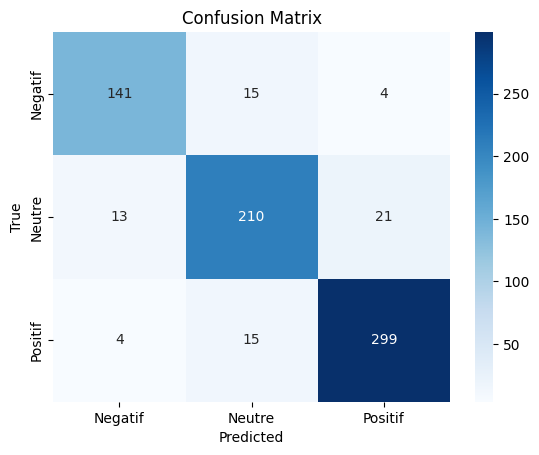

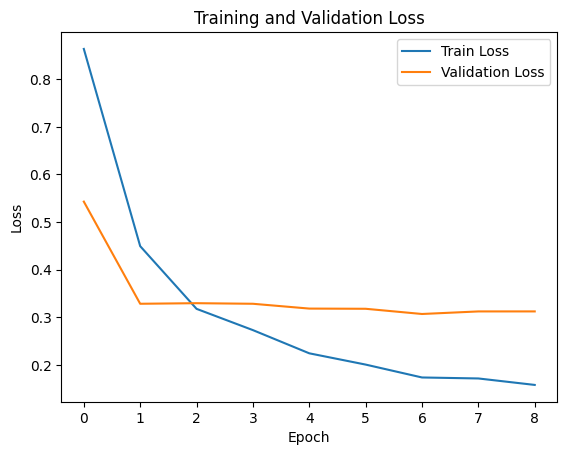

In [9]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import functional as F
from torch import nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random

# Configuration du device GPU uniquement
assert torch.cuda.is_available(), "CUDA GPU is not available."
device = torch.device("cuda")

# 1. Chargement des données
df = pd.read_csv("/content/Comments_clean.csv").dropna(subset=["Comments"])

# 2. Encodage des sentiments
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])
num_labels = len(label_encoder.classes_)

# 3. Tokenizer et Dataset
tokenizer = AutoTokenizer.from_pretrained("alger-ia/dziribert")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# 4. Split dataset (Train 70%, Test 20%, Val 10%)
dataset = SentimentDataset(df["Comments"].values, df["Sentiments_encoded"].values, tokenizer)
total_size = len(dataset)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
val_size = total_size - train_size - test_size
train_set, test_set, val_set = random_split(dataset, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

# 5. Chargement du modèle avec dropout custom
config = AutoConfig.from_pretrained("alger-ia/dziribert", num_labels=num_labels, hidden_dropout_prob=0.4)
model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config)
model.to(device)

# 6. Optimiseur et Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, eps=0.0001)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=75, num_training_steps=num_training_steps)

# 7. Entraînement avec Early Stopping
best_val_loss = float("inf")
patience, patience_counter = 2, 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\\n🟢 Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"✅ Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# 8. Évaluation finale
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
all_preds, all_labels = [], []

for batch in test_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print("\\n🔍 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 9. Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 10. Courbes des pertes
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

----


📂 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔁 Epoch 1/10


Val: 100%|██████████| 46/46 [00:05<00:00,  9.00it/s]


✅ Train Acc: 0.6105 | Val Acc: 0.8506

🔁 Epoch 2/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.88it/s]


✅ Train Acc: 0.8416 | Val Acc: 0.8907

🔁 Epoch 3/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.88it/s]


✅ Train Acc: 0.8910 | Val Acc: 0.8976

🔁 Epoch 4/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.83it/s]


✅ Train Acc: 0.9184 | Val Acc: 0.9032

🔁 Epoch 5/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.80it/s]


✅ Train Acc: 0.9204 | Val Acc: 0.9018
⛔ Early stopping


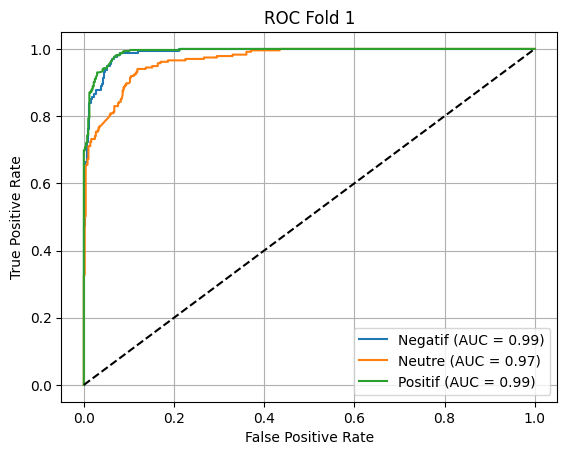


📂 Fold 2/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔁 Epoch 1/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.84it/s]


✅ Train Acc: 0.6271 | Val Acc: 0.8257

🔁 Epoch 2/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.92it/s]


✅ Train Acc: 0.8454 | Val Acc: 0.8935

🔁 Epoch 3/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.89it/s]


✅ Train Acc: 0.8737 | Val Acc: 0.9004

🔁 Epoch 4/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.93it/s]


✅ Train Acc: 0.9087 | Val Acc: 0.9101

🔁 Epoch 5/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.87it/s]


✅ Train Acc: 0.9153 | Val Acc: 0.9046

🔁 Epoch 6/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.79it/s]


✅ Train Acc: 0.9294 | Val Acc: 0.9129
⛔ Early stopping


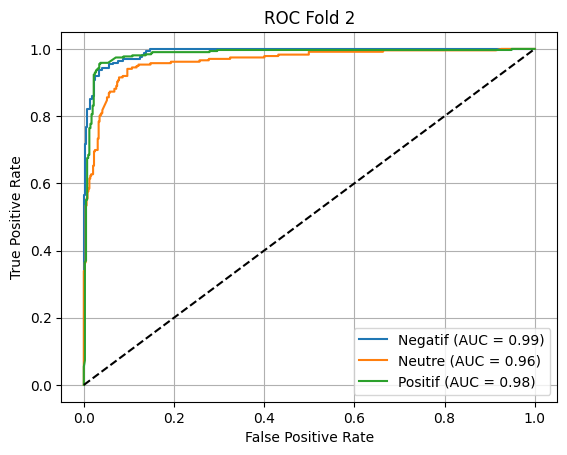


📂 Fold 3/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔁 Epoch 1/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.83it/s]


✅ Train Acc: 0.6147 | Val Acc: 0.8340

🔁 Epoch 2/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.82it/s]


✅ Train Acc: 0.8526 | Val Acc: 0.8811

🔁 Epoch 3/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.87it/s]


✅ Train Acc: 0.8831 | Val Acc: 0.8852

🔁 Epoch 4/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.79it/s]


✅ Train Acc: 0.9104 | Val Acc: 0.8907

🔁 Epoch 5/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.84it/s]


✅ Train Acc: 0.9184 | Val Acc: 0.8907
⛔ Early stopping


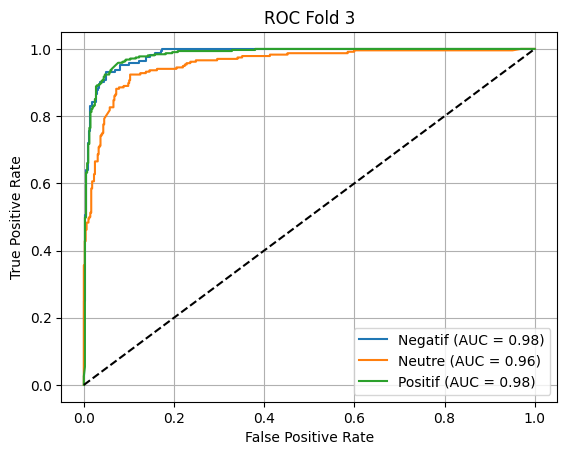


📂 Fold 4/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔁 Epoch 1/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.82it/s]


✅ Train Acc: 0.6268 | Val Acc: 0.8548

🔁 Epoch 2/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.86it/s]


✅ Train Acc: 0.8443 | Val Acc: 0.8893

🔁 Epoch 3/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.90it/s]


✅ Train Acc: 0.8838 | Val Acc: 0.8990

🔁 Epoch 4/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.87it/s]


✅ Train Acc: 0.9121 | Val Acc: 0.9004

🔁 Epoch 5/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.84it/s]


✅ Train Acc: 0.9184 | Val Acc: 0.9073

🔁 Epoch 6/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.87it/s]


✅ Train Acc: 0.9339 | Val Acc: 0.8990

🔁 Epoch 7/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.78it/s]


✅ Train Acc: 0.9332 | Val Acc: 0.9212
⛔ Early stopping


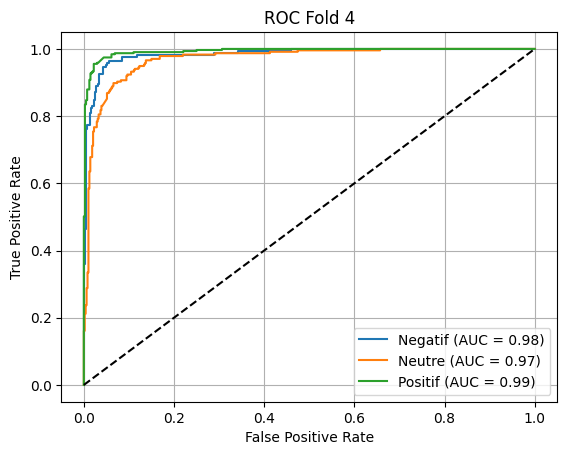


📂 Fold 5/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔁 Epoch 1/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.86it/s]


✅ Train Acc: 0.6279 | Val Acc: 0.8629

🔁 Epoch 2/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.90it/s]


✅ Train Acc: 0.8444 | Val Acc: 0.8961

🔁 Epoch 3/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.88it/s]


✅ Train Acc: 0.8932 | Val Acc: 0.8975

🔁 Epoch 4/10


Val: 100%|██████████| 46/46 [00:05<00:00,  8.79it/s]


✅ Train Acc: 0.9156 | Val Acc: 0.8975

🔁 Epoch 5/10


Train:   1%|          | 2/181 [00:00<01:01,  2.91it/s]

In [ ]:
# === Imports ===
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_scheduler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

# === Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "alger-ia/dziribert"
num_folds = 5
num_epochs = 10
batch_size = 16
patience = 2

# === Chargement des données ===
df = pd.read_csv("/content/Comments_clean.csv").dropna(subset=["Comments"])
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])
num_labels = len(label_encoder.classes_)

# === Dataset Class ===
tokenizer = AutoTokenizer.from_pretrained(model_name)

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# === Préparation des données pour K-Fold ===
X = df["Comments"].values
y = df["Sentiments_encoded"].values
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

train_accs, val_accs = [], []
train_losses, val_losses = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n📂 Fold {fold+1}/{num_folds}")

    train_dataset = SentimentDataset(X[train_idx], y[train_idx], tokenizer)
    val_dataset = SentimentDataset(X[val_idx], y[val_idx], tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    config = AutoConfig.from_pretrained(model_name, num_labels=num_labels, hidden_dropout_prob=0.4)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, eps=1e-8)
    total_steps = num_epochs * len(train_loader)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=75, num_training_steps=total_steps)

    best_val_loss = float("inf")
    patience_counter = 0
    fold_train_loss, fold_val_loss = [], []
    fold_train_acc, fold_val_acc = [], []

    for epoch in range(num_epochs):
        print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
        model.train()
        total_loss, correct, total = 0, 0, 0

        for batch in tqdm(train_loader, desc="Train"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        fold_train_acc.append(acc)
        fold_train_loss.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_preds, all_true, all_probs = [], [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Val"):
                inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
                labels = batch["labels"].to(device)
                outputs = model(**inputs, labels=labels)

                val_loss += outputs.loss.item()
                probs = torch.softmax(outputs.logits, dim=1)
                preds = torch.argmax(probs, dim=1)

                all_probs.append(probs.cpu())
                all_preds.extend(preds.cpu().numpy())
                all_true.extend(labels.cpu().numpy())
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        fold_val_acc.append(val_acc)
        fold_val_loss.append(val_loss / len(val_loader))

        print(f"✅ Train Acc: {acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⛔ Early stopping")
                break

    train_accs.append(fold_train_acc)
    val_accs.append(fold_val_acc)
    train_losses.append(fold_train_loss)
    val_losses.append(fold_val_loss)

    # ROC-AUC
    all_probs = torch.cat(all_probs, dim=0).numpy()
    y_bin = label_binarize(all_true, classes=np.arange(num_labels))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_labels):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Courbe ROC
    plt.figure()
    for i in range(num_labels):
        plt.plot(fpr[i], tpr[i], label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Fold {fold+1}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

  # Moyennes sur les folds
avg_train_acc = np.mean(train_accs, axis=0)
avg_val_acc = np.mean(val_accs, axis=0)
avg_train_loss = np.mean(train_losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)

# Courbe Accuracy
plt.plot(avg_train_acc, label="Train Accuracy")
plt.plot(avg_val_acc, label="Validation Accuracy")
plt.title("Train vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Courbe Loss
plt.plot(avg_train_loss, label="Train Loss")
plt.plot(avg_val_loss, label="Validation Loss")
plt.title("Train vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

